In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import savemat
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy import stats
import seaborn as sns
import os
import glob
from scipy.interpolate import interp2d


df_sol = pd.read_csv("solution.csv")
df_prodHist = pd.read_csv("production_history.csv")
df_preProc = pd.read_csv("wellbore_data_preproduction_well.csv")
df_producer = pd.read_csv("wellbore_data_producer_wells.csv")
df_complete = pd.read_csv("wellbore_data_producer_wells_cleaned_complete.csv")


AI = np.load("2d_ai.npy")
sandFraction = np.load("2d_sand_propotion.npy")
shalySandFraction = np.load("2d_shaly_sand_propotion.npy")
shaleFraction = np.load("2d_shale_propotion.npy")
sandyShaleFraction = np.load("2d_sandy_shale_propotion.npy")
topDepth = np.load("2d_top_depth.npy")
resFraction = sandFraction + sandyShaleFraction
nonresFraction = shalySandFraction + shaleFraction
region = np.empty((200,200)); region
region[:] = 2
region[sandFraction < 0.05] = 1
region[resFraction > 0.43] = 3


x = np.arange(0,10,0.05); y = np.arange(0,10,0.05);
xf = np.linspace(1.750,10,16); zf = np.linspace(-3040,-3070,16)
x2d, y2d = np.meshgrid(x,y);
x2df, z2df = np.meshgrid(xf,zf); y2df = 11.75 - x2df;
woc2d = np.full((200, 200), -3067.4)

gridarray = np.transpose(np.stack((AI.flatten(),resFraction.flatten(),topDepth.flatten(),x2d.flatten(),y2d.flatten(),region.flatten())));
df_grid = pd.DataFrame(gridarray, columns = ['AI','Reservoir Fraction','Depth','X','Y','Region'])
# pd.plotting.scatter_matrix(df_grid)

well_x_index = ((df_complete['X, m'].values-25)/50).astype('int')
well_y_index = ((df_complete['Y, m'].values-25)/50).astype('int')
df_complete['AI from Map'] = AI[well_x_index,well_y_index]
df_complete['resFraction from Map'] = resFraction[well_x_index,well_y_index]
df_complete['Region'] = region[well_x_index,well_y_index]
df_complete['Top Depth'] = topDepth[well_x_index,well_y_index]
df_complete['WOR'] = df_complete['Cum_wat_prod_3_yr']/df_complete['Cum_oil_prod_3_yr']
df_complete['Total Prod'] = df_complete['Cum_oil_prod_3_yr']+df_complete['Cum_wat_prod_3_yr']


for i in range(1,84):
    df_complete.loc[df_complete['Well_ID'] == 'Well_no_{}'.format(i), 'Well Top'] = df_complete[df_complete['Well_ID'] == "Well_no_{}".format(i)]['Depth, m'].min()
    df_complete.loc[df_complete['Well_ID'] == 'Well_no_{}'.format(i), 'Well Bottom'] = df_complete[df_complete['Well_ID'] == "Well_no_{}".format(i)]['Depth, m'].max()
    df_complete.loc[df_complete['Well_ID'] == 'Well_no_{}'.format(i), 'AI averaged'] = df_complete[df_complete['Well_ID'] == "Well_no_{}".format(i)]['Acoustic Impedance, kg*s/m^2'].median()

<IPython.core.display.Javascript object>


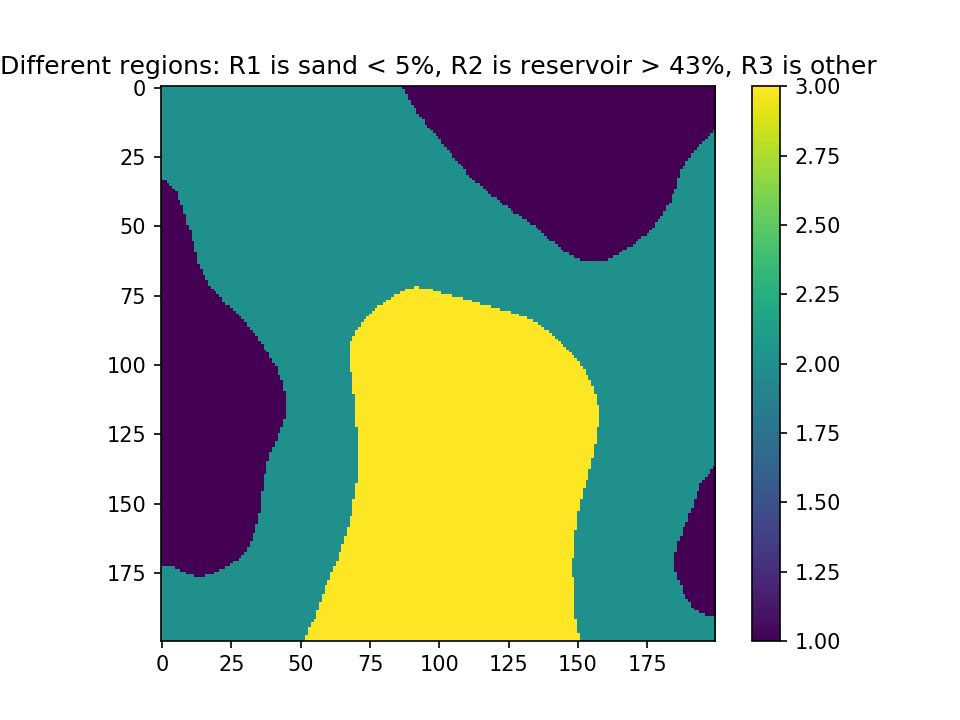

Text(0.5, 1.0, 'Different regions: R1 is sand < 5%, R2 is reservoir > 43%, R3 is other')

In [2]:
plt.figure()
plt.imshow(region)
plt.colorbar()
plt.title('Different regions: R1 is sand < 5%, R2 is reservoir > 43%, R3 is other')

<IPython.core.display.Javascript object>


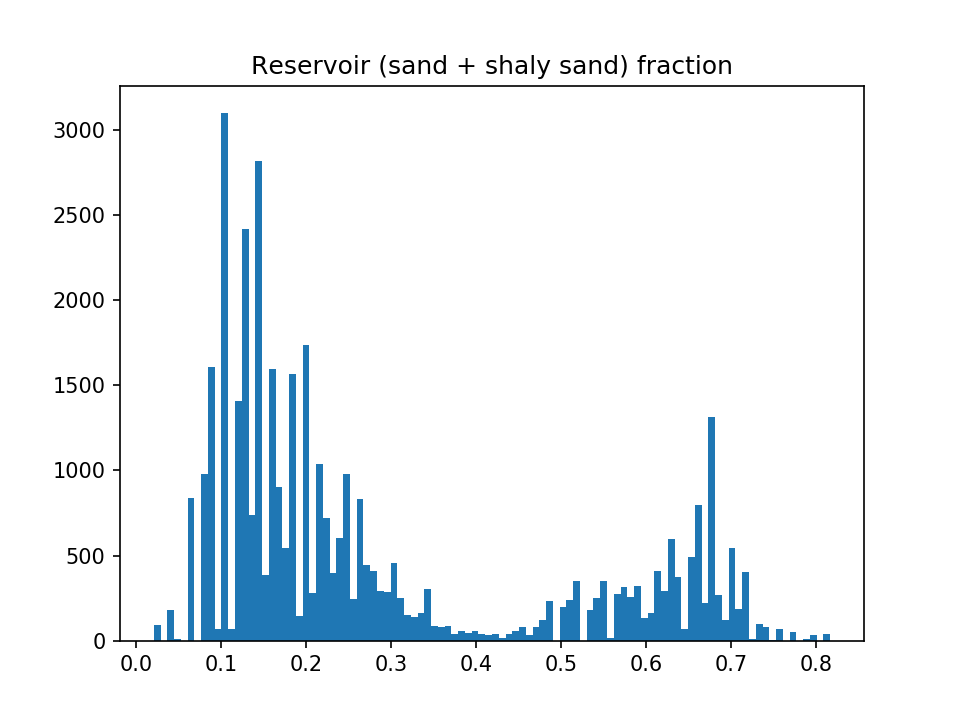

Text(0.5, 1.0, 'Reservoir (sand + shaly sand) fraction')

In [3]:
plt.figure()
plt.hist(resFraction.flatten(), bins = 100)
plt.title('Reservoir (sand + shaly sand) fraction')

<IPython.core.display.Javascript object>


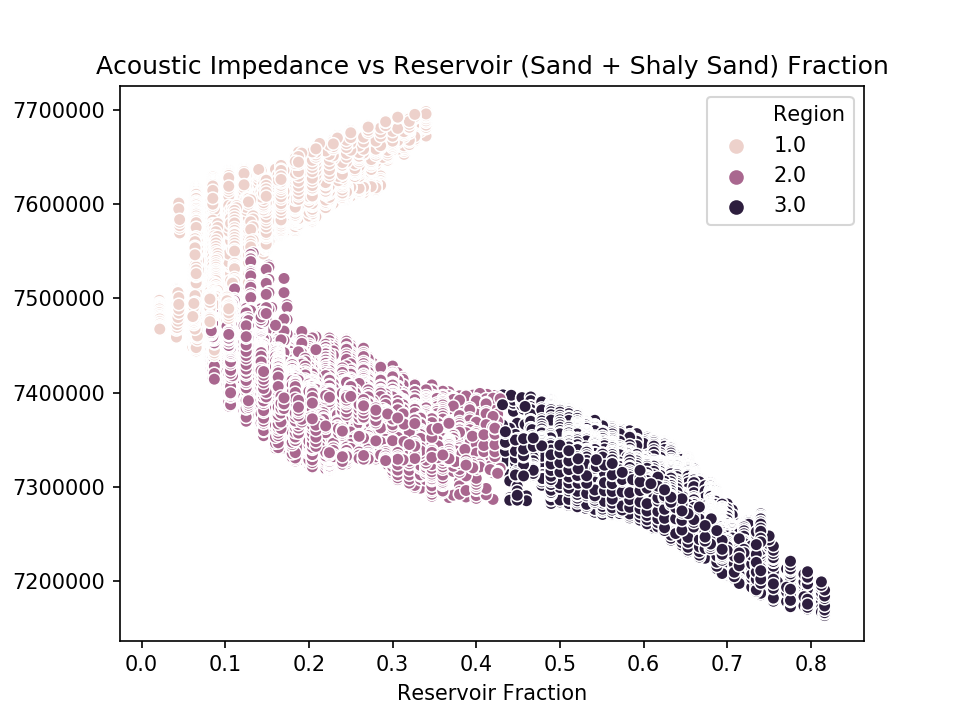

Text(0.5, 1.0, 'Acoustic Impedance vs Reservoir (Sand + Shaly Sand) Fraction')

In [4]:
plt.figure()
sns.scatterplot(data = df_grid, x = 'Reservoir Fraction', y = 'AI', hue = 'Region', legend="full")
plt.title('Acoustic Impedance vs Reservoir (Sand + Shaly Sand) Fraction')

<IPython.core.display.Javascript object>


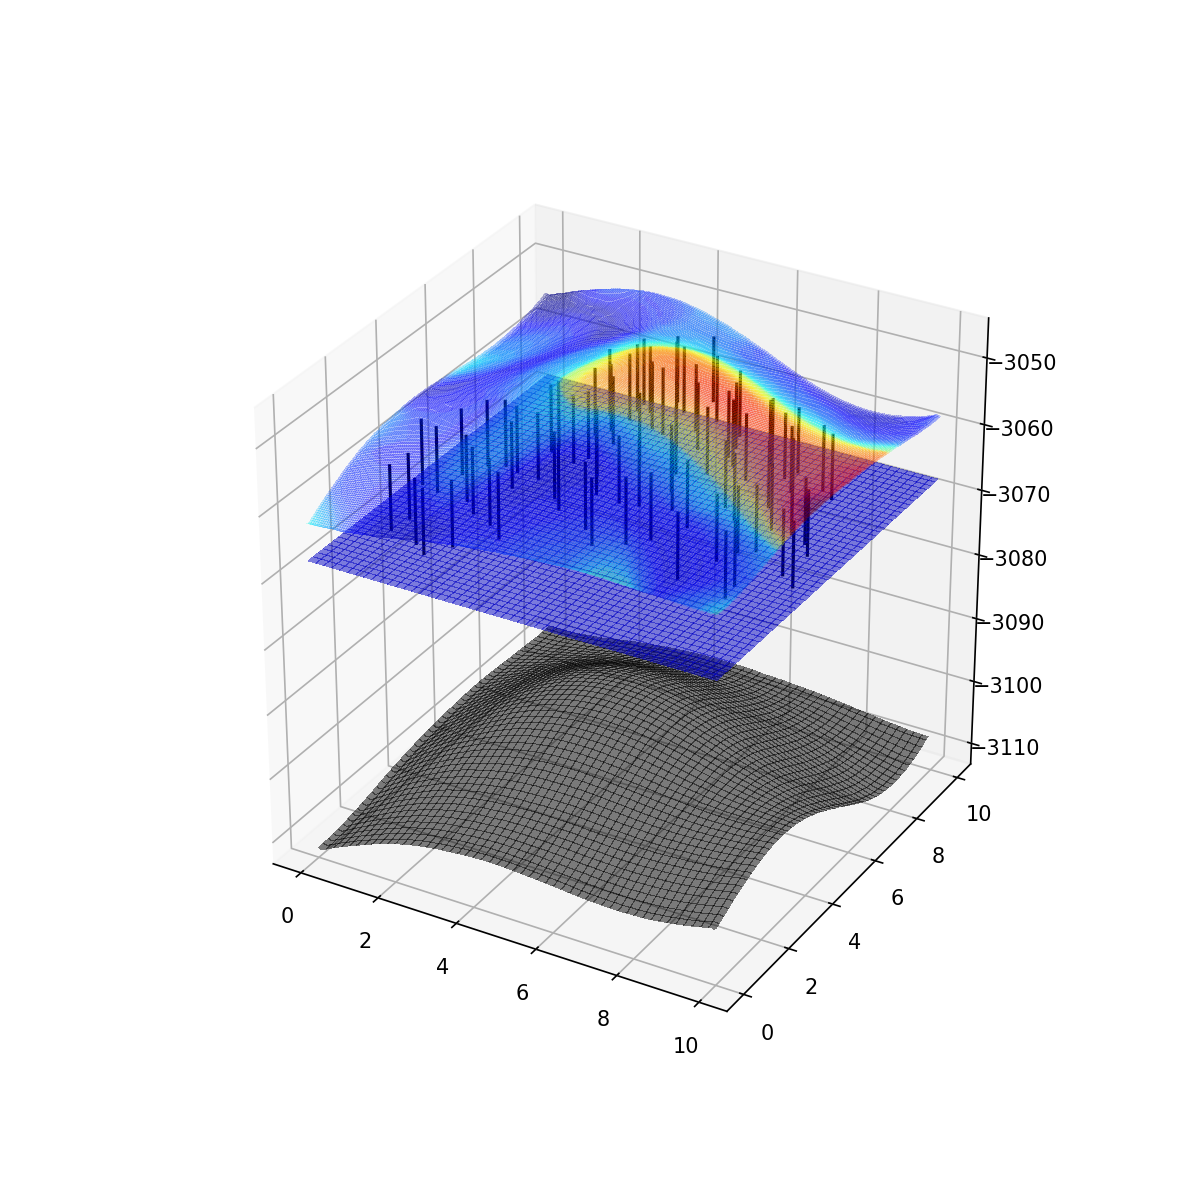

In [5]:


# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = resFraction # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (8,8))
surf = ax.plot_surface(y2d, x2d, -topDepth,
                       linewidth=0, antialiased=False, alpha = 0.2, rstride=1, 
                       cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)
#surf2 = ax.plot_surface(x2df, y2df, z2df,
#                       linewidth=0, antialiased=False, alpha=0.1, color = 'black')
surf3 = ax.plot_surface(x2d, y2d, -topDepth-50,
                       linewidth=0, antialiased=False, alpha=0.5, color = 'black')
surf4 = ax.plot_surface(x2d, y2d, woc2d,
                       linewidth=0, antialiased=False, alpha=0.5, color = 'blue')
for i in range (1,84):
    ax.plot((df_complete[df_complete['Well_ID'] == "Well_no_{}".format(i)]['Y, m'])/1000,
             (df_complete[df_complete['Well_ID'] == "Well_no_{}".format(i)]['X, m'])/1000,
             -df_complete[df_complete['Well_ID'] == "Well_no_{}".format(i)]['Depth, m'], color = 'black')





In [6]:
rho = df_complete['Density, g/cm3'].values*1000
Vs = df_complete['Shear velocity, m/s'].values
Vp = df_complete['Compressible velocity, m/s'].values
G = df_complete['Shear modulus, GPa'].values
VpVs = Vp/Vs

df_complete['comp_ShearMod'] = rho*Vs**2*1e-9
df_complete['comp_AI'] = rho*Vp
df_complete['comp_YoungModulus'] = G*(3*Vp**2*1e-9-4*G)/(Vp**2*1e-9 - G)
df_complete['comp_BulkModulus'] = rho*Vp**2*1e-9 - 4*G/3
df_complete['comp_MModulus'] = rho*Vp**2*1e-9
df_complete['comp_Lame'] = rho*Vp**2*1e-9 - 2*G
df_complete['comp_poisson'] = (rho*Vp**2*1e-9 - 2*G)/(2*rho*Vp**2*1e-9 - 2*G)
df_complete['comp_VpVs'] = Vp/Vs

<IPython.core.display.Javascript object>


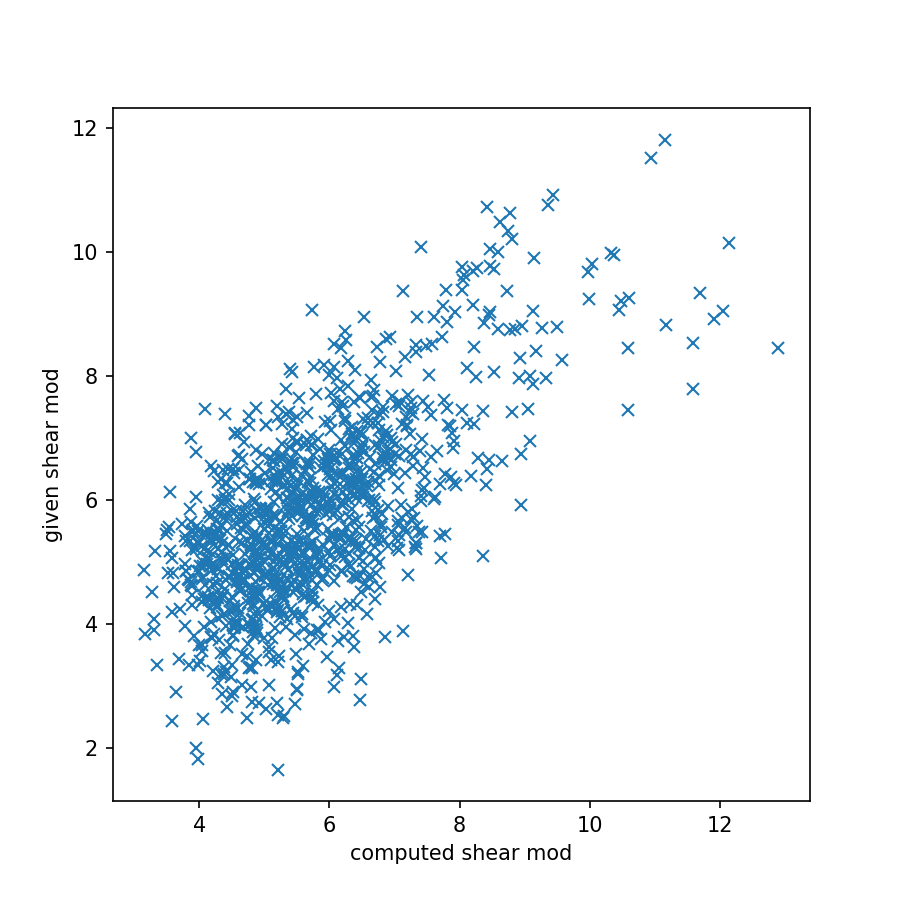

1.0161278813357482
0.22089473636563248


In [7]:
plt.figure(figsize = (6,6))
plt.plot(df_complete['comp_ShearMod'], df_complete['Shear modulus, GPa'], 'x')
plt.xlabel('computed shear mod')
plt.ylabel('given shear mod')

print(np.mean(df_complete['Shear modulus, GPa']/df_complete['comp_ShearMod']))
print(np.std(df_complete['Shear modulus, GPa']/df_complete['comp_ShearMod']))

<IPython.core.display.Javascript object>


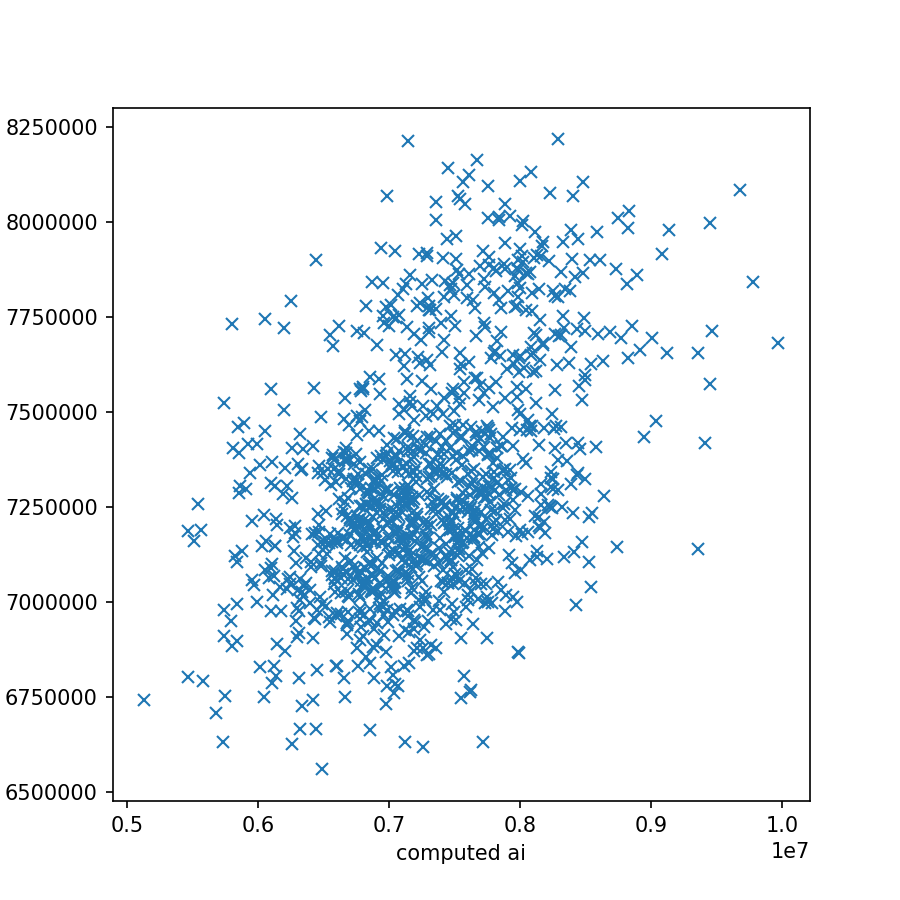

1.0125895199894486
0.0871033229402982


In [8]:
plt.figure(figsize = (6,6))
plt.plot(df_complete['comp_AI'], df_complete['Acoustic Impedance, kg*s/m^2'], 'x')
plt.xlabel('computed ai')
plt.ylabel('given ai')

print(np.mean(df_complete['Acoustic Impedance, kg*s/m^2']/df_complete['comp_AI']))
print(np.std(df_complete['Acoustic Impedance, kg*s/m^2']/df_complete['comp_AI']))

<IPython.core.display.Javascript object>


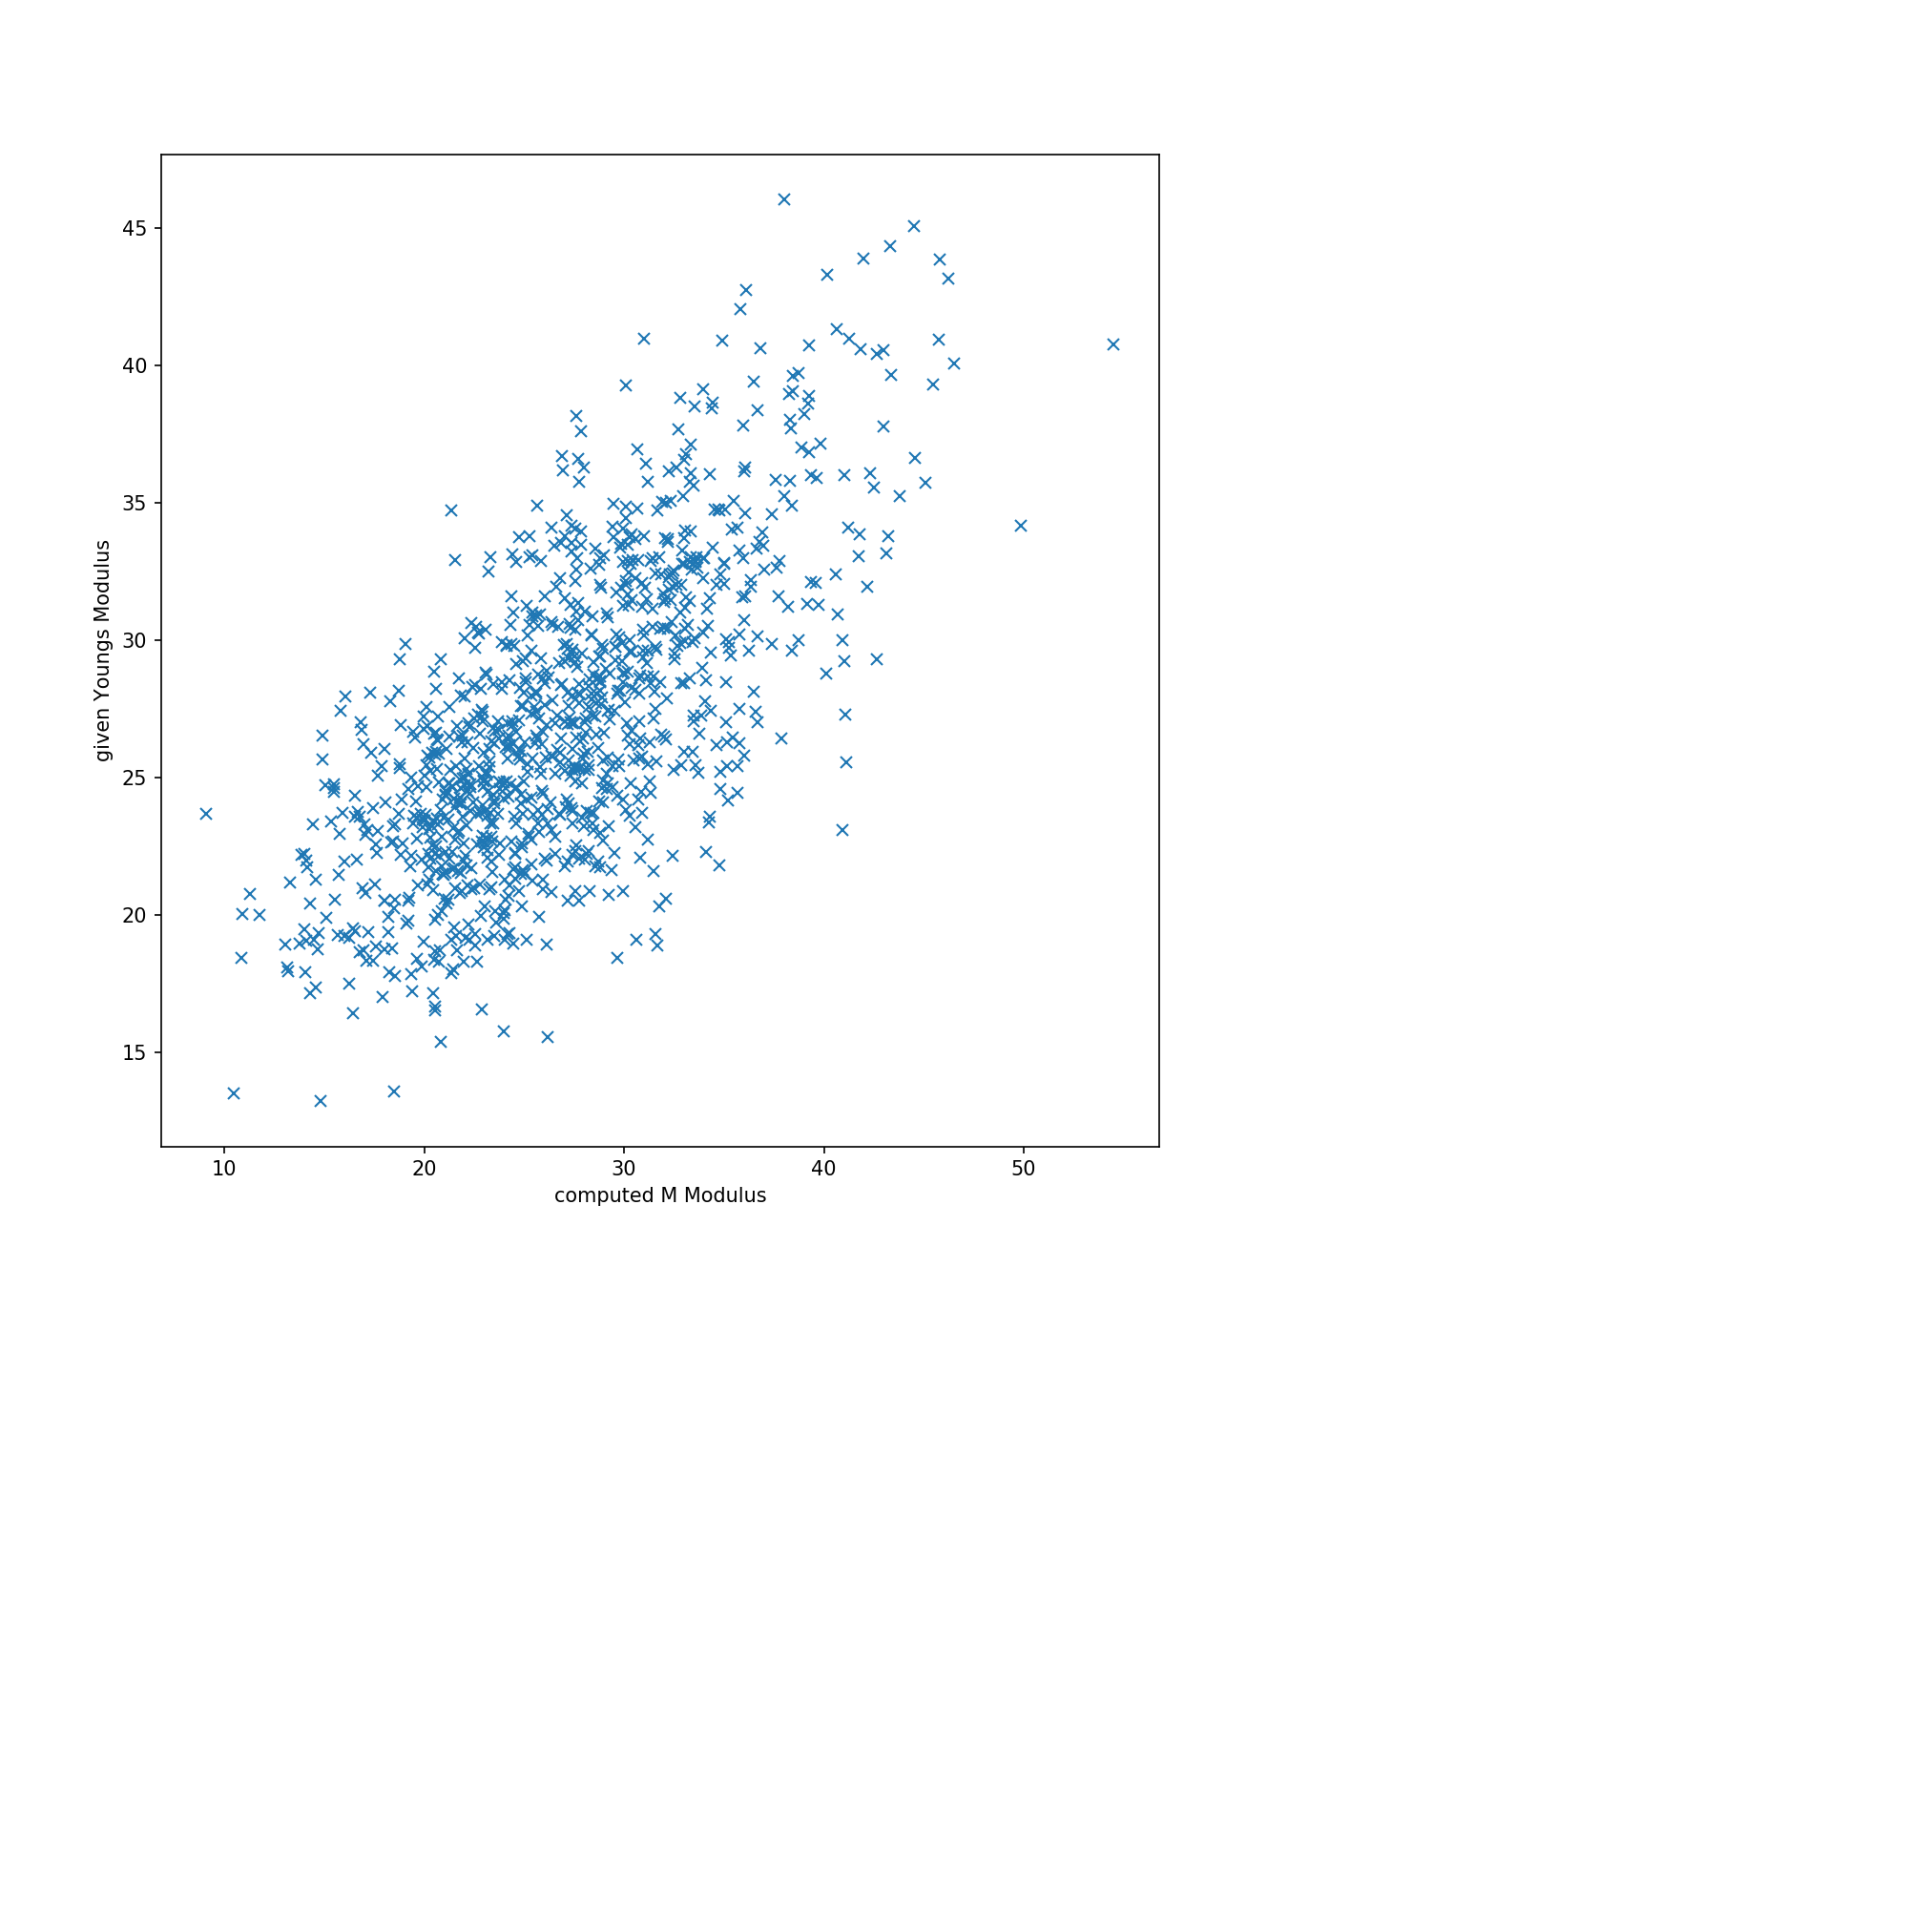

1.0364060859358406
0.20235410418573446


In [9]:
plt.figure(figsize = (9,9))
plt.plot(df_complete['comp_MModulus'].values, df_complete['Youngs modulus, GPa'].values, 'x')
plt.xlabel('computed M Modulus')
plt.ylabel('given Youngs Modulus')

print(np.mean(df_complete['Youngs modulus, GPa']/df_complete['comp_MModulus']))
print(np.std(df_complete['Youngs modulus, GPa']/df_complete['comp_MModulus']))

<IPython.core.display.Javascript object>


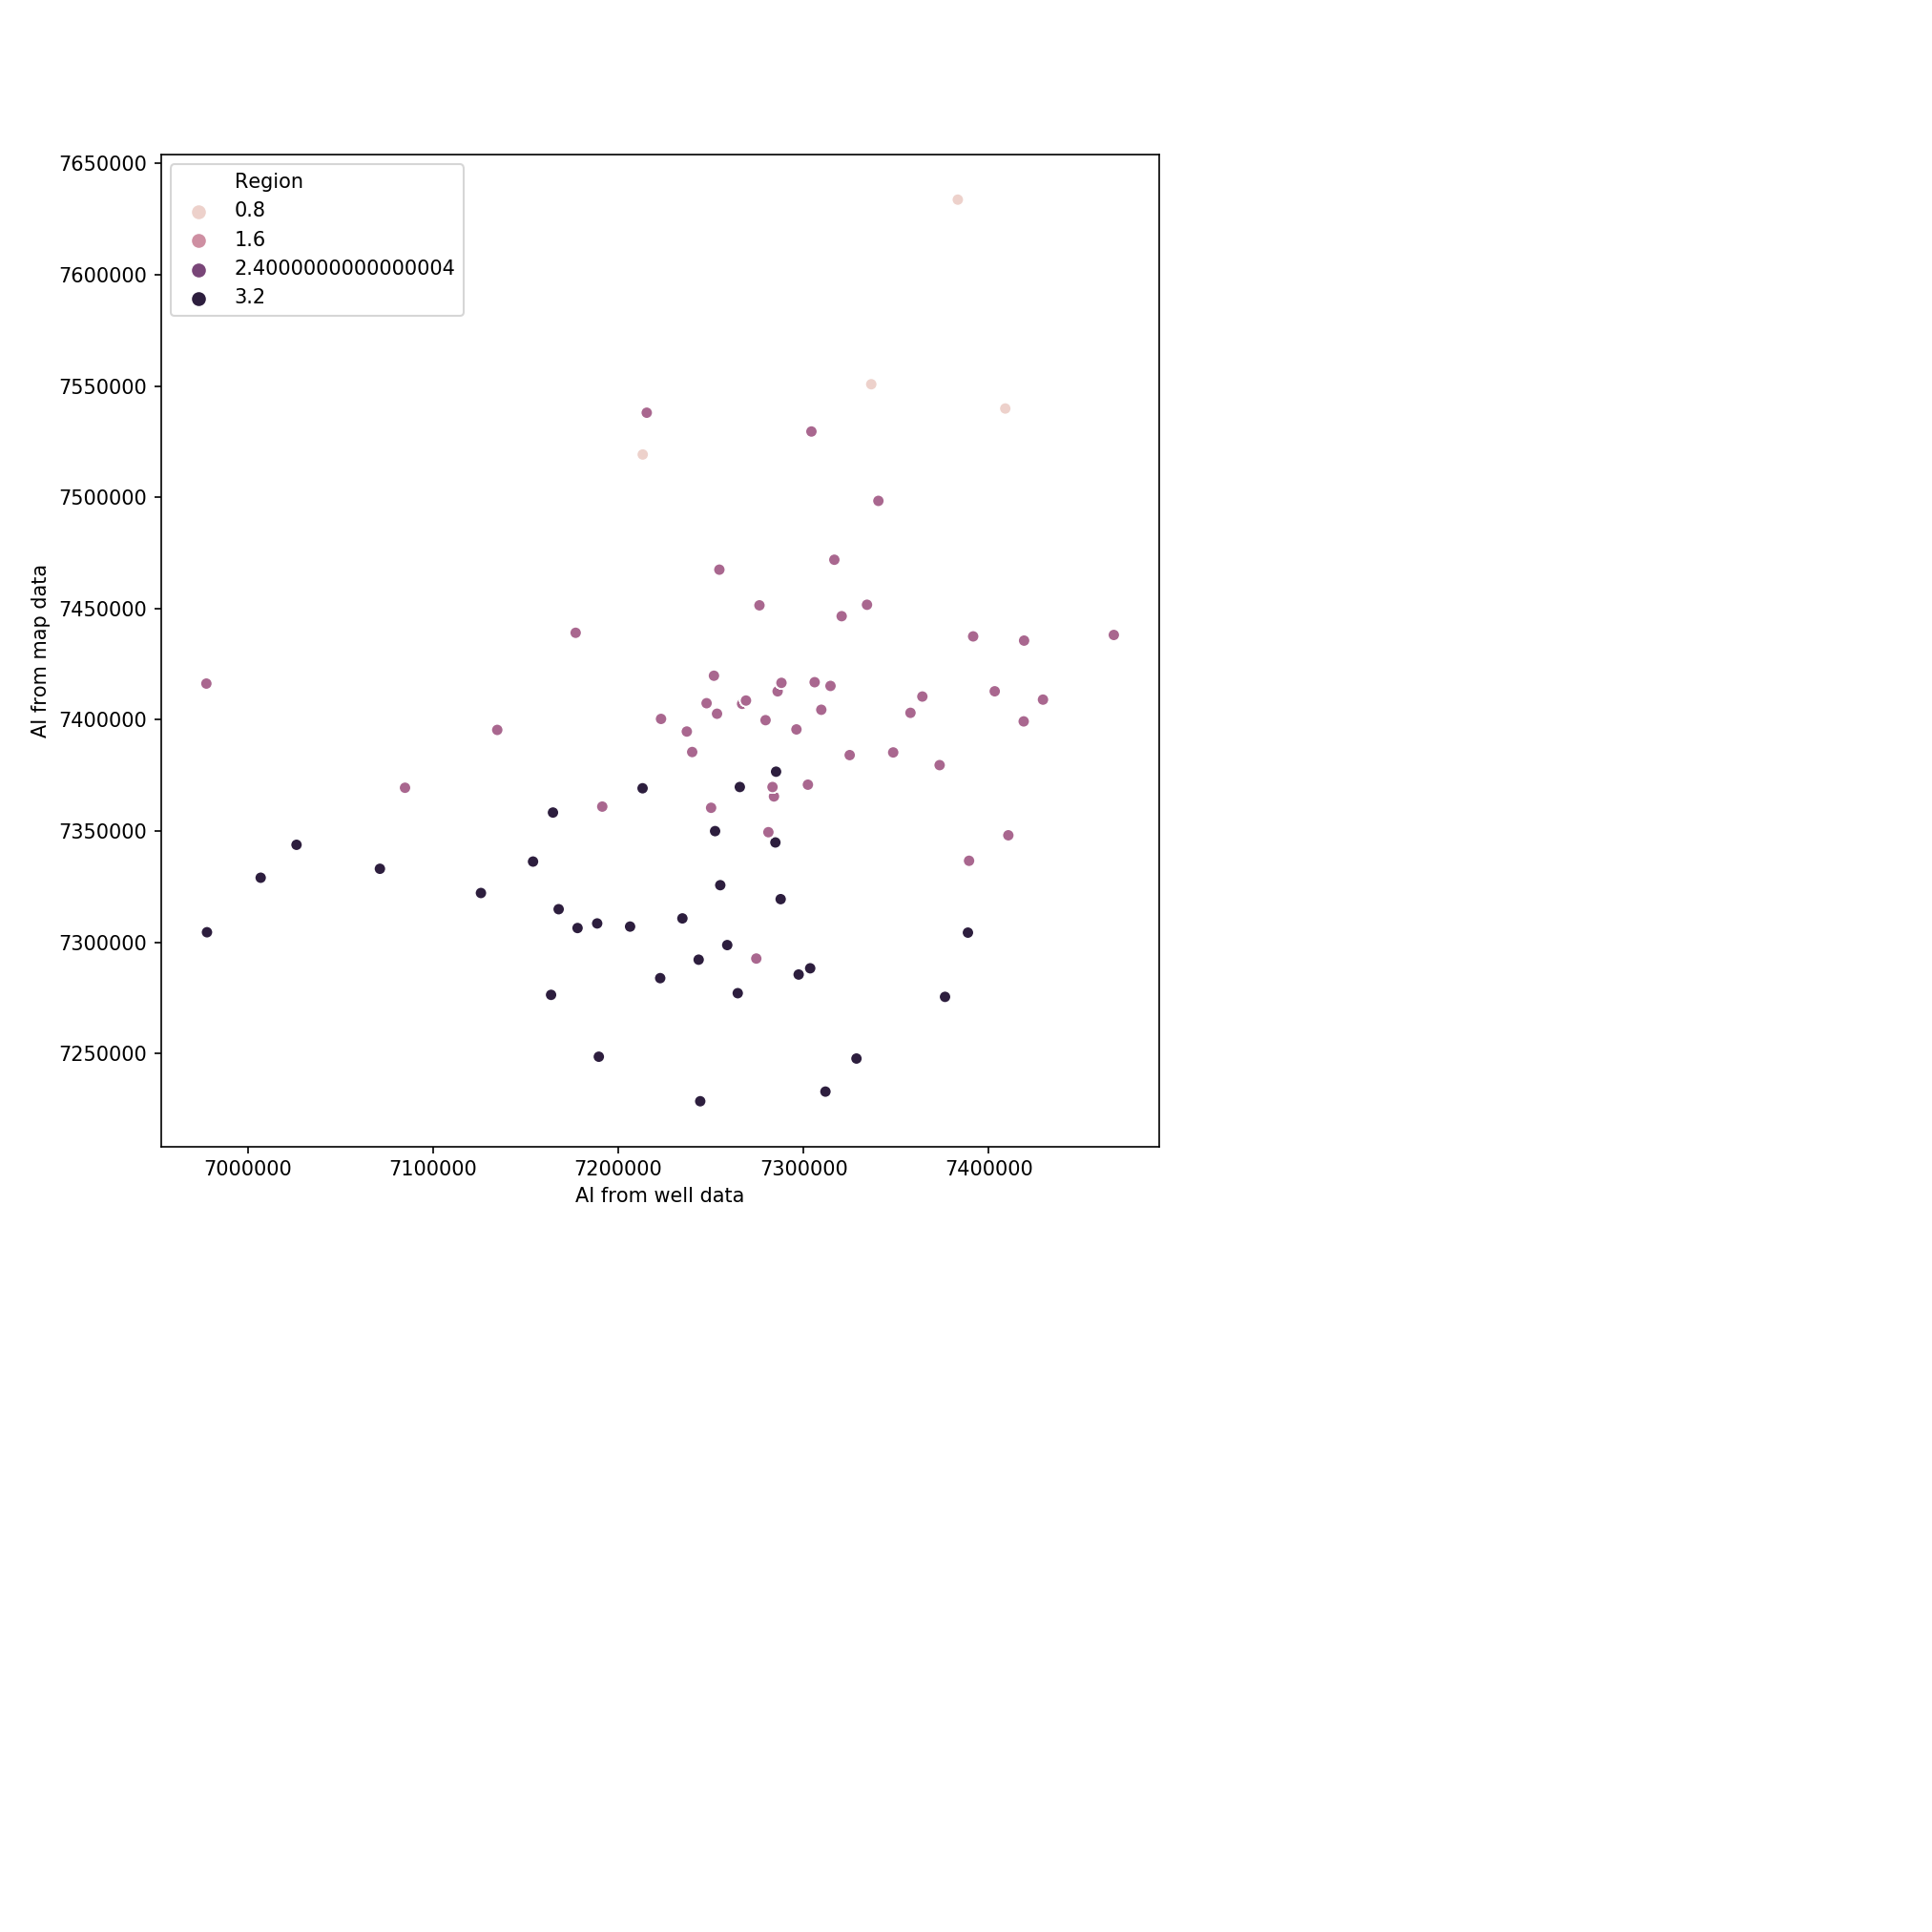

1.0155336116954317
0.014939493890559525


In [10]:
plt.figure(figsize = (9,9))
sns.scatterplot(data = df_complete, x = 'AI averaged', y = 'AI from Map', hue = 'Region')
#plt.plot(df_clean['Acoustic Impedance, kg*s/m^2'].values, df_clean['AI from Map'].values, 'x')
plt.ylabel('AI from map data')
plt.xlabel('AI from well data')

print(np.mean(df_complete['AI from Map']/df_complete['AI averaged']))
print(np.std(df_complete['AI from Map']/df_complete['AI averaged']))

<IPython.core.display.Javascript object>


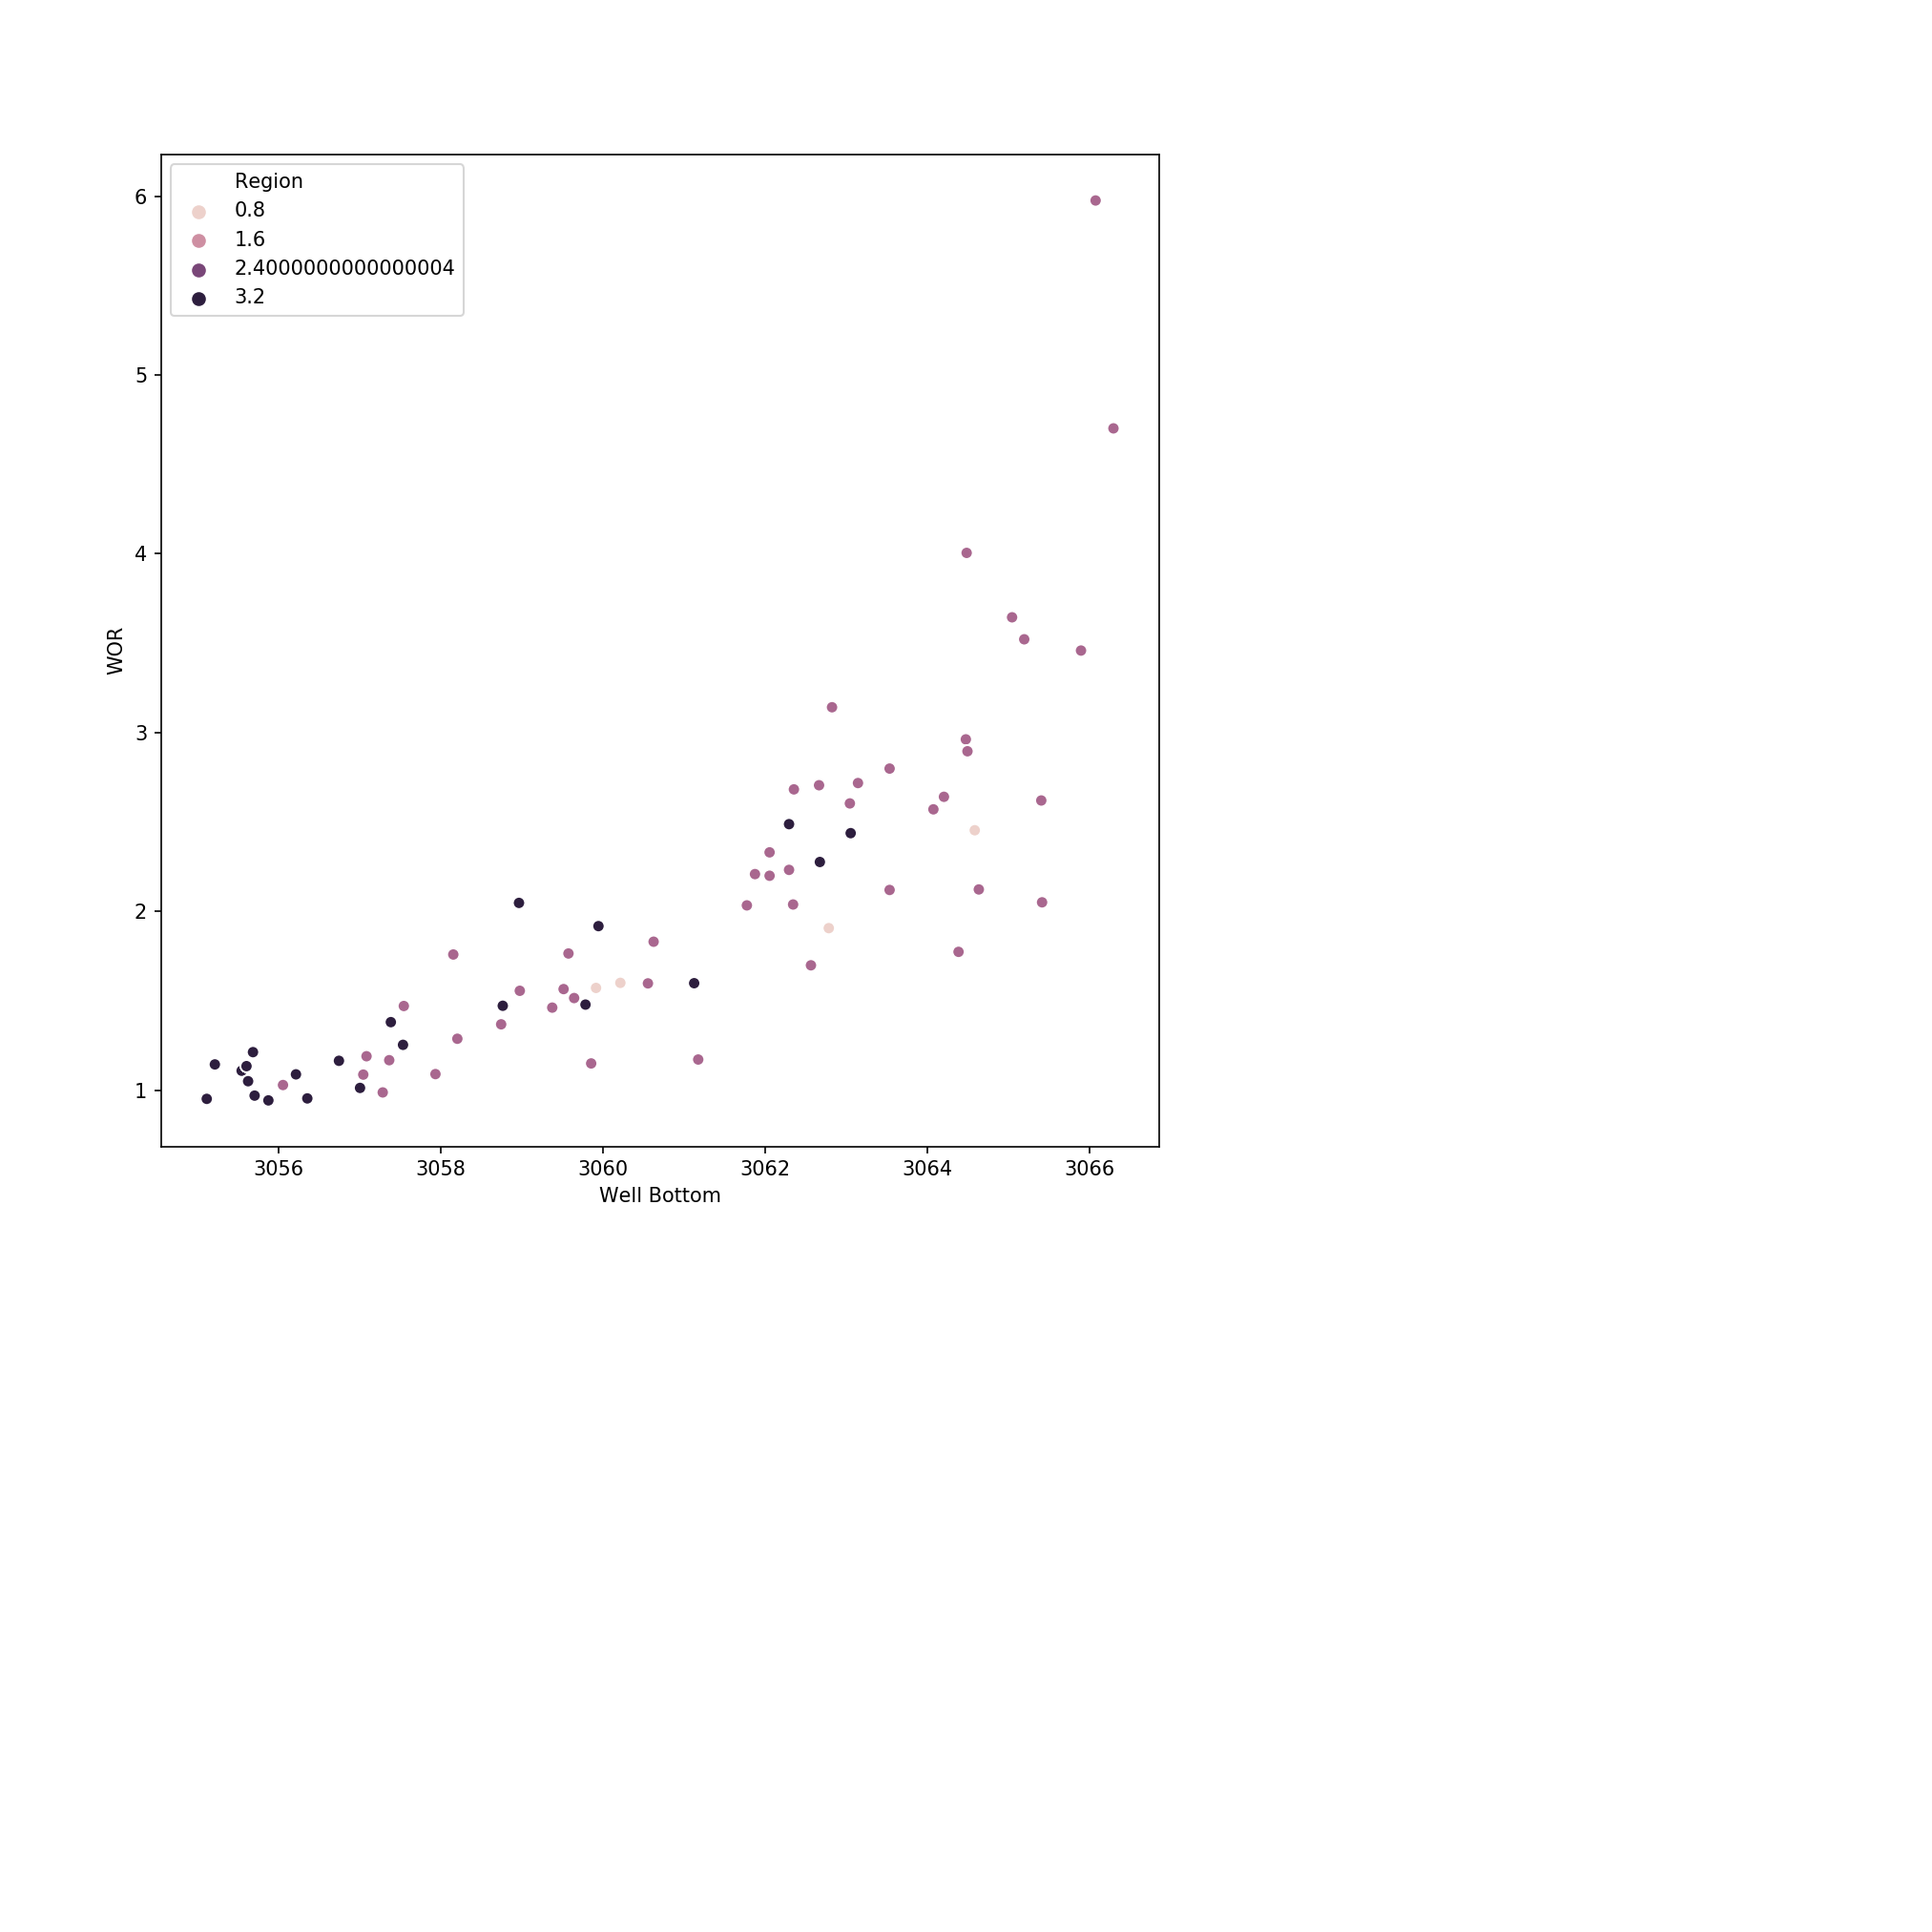

In [11]:
plt.figure(figsize = (9,9))
sns.scatterplot(data = df_complete, x = 'Well Bottom', y = 'WOR', hue = 'Region')

<IPython.core.display.Javascript object>


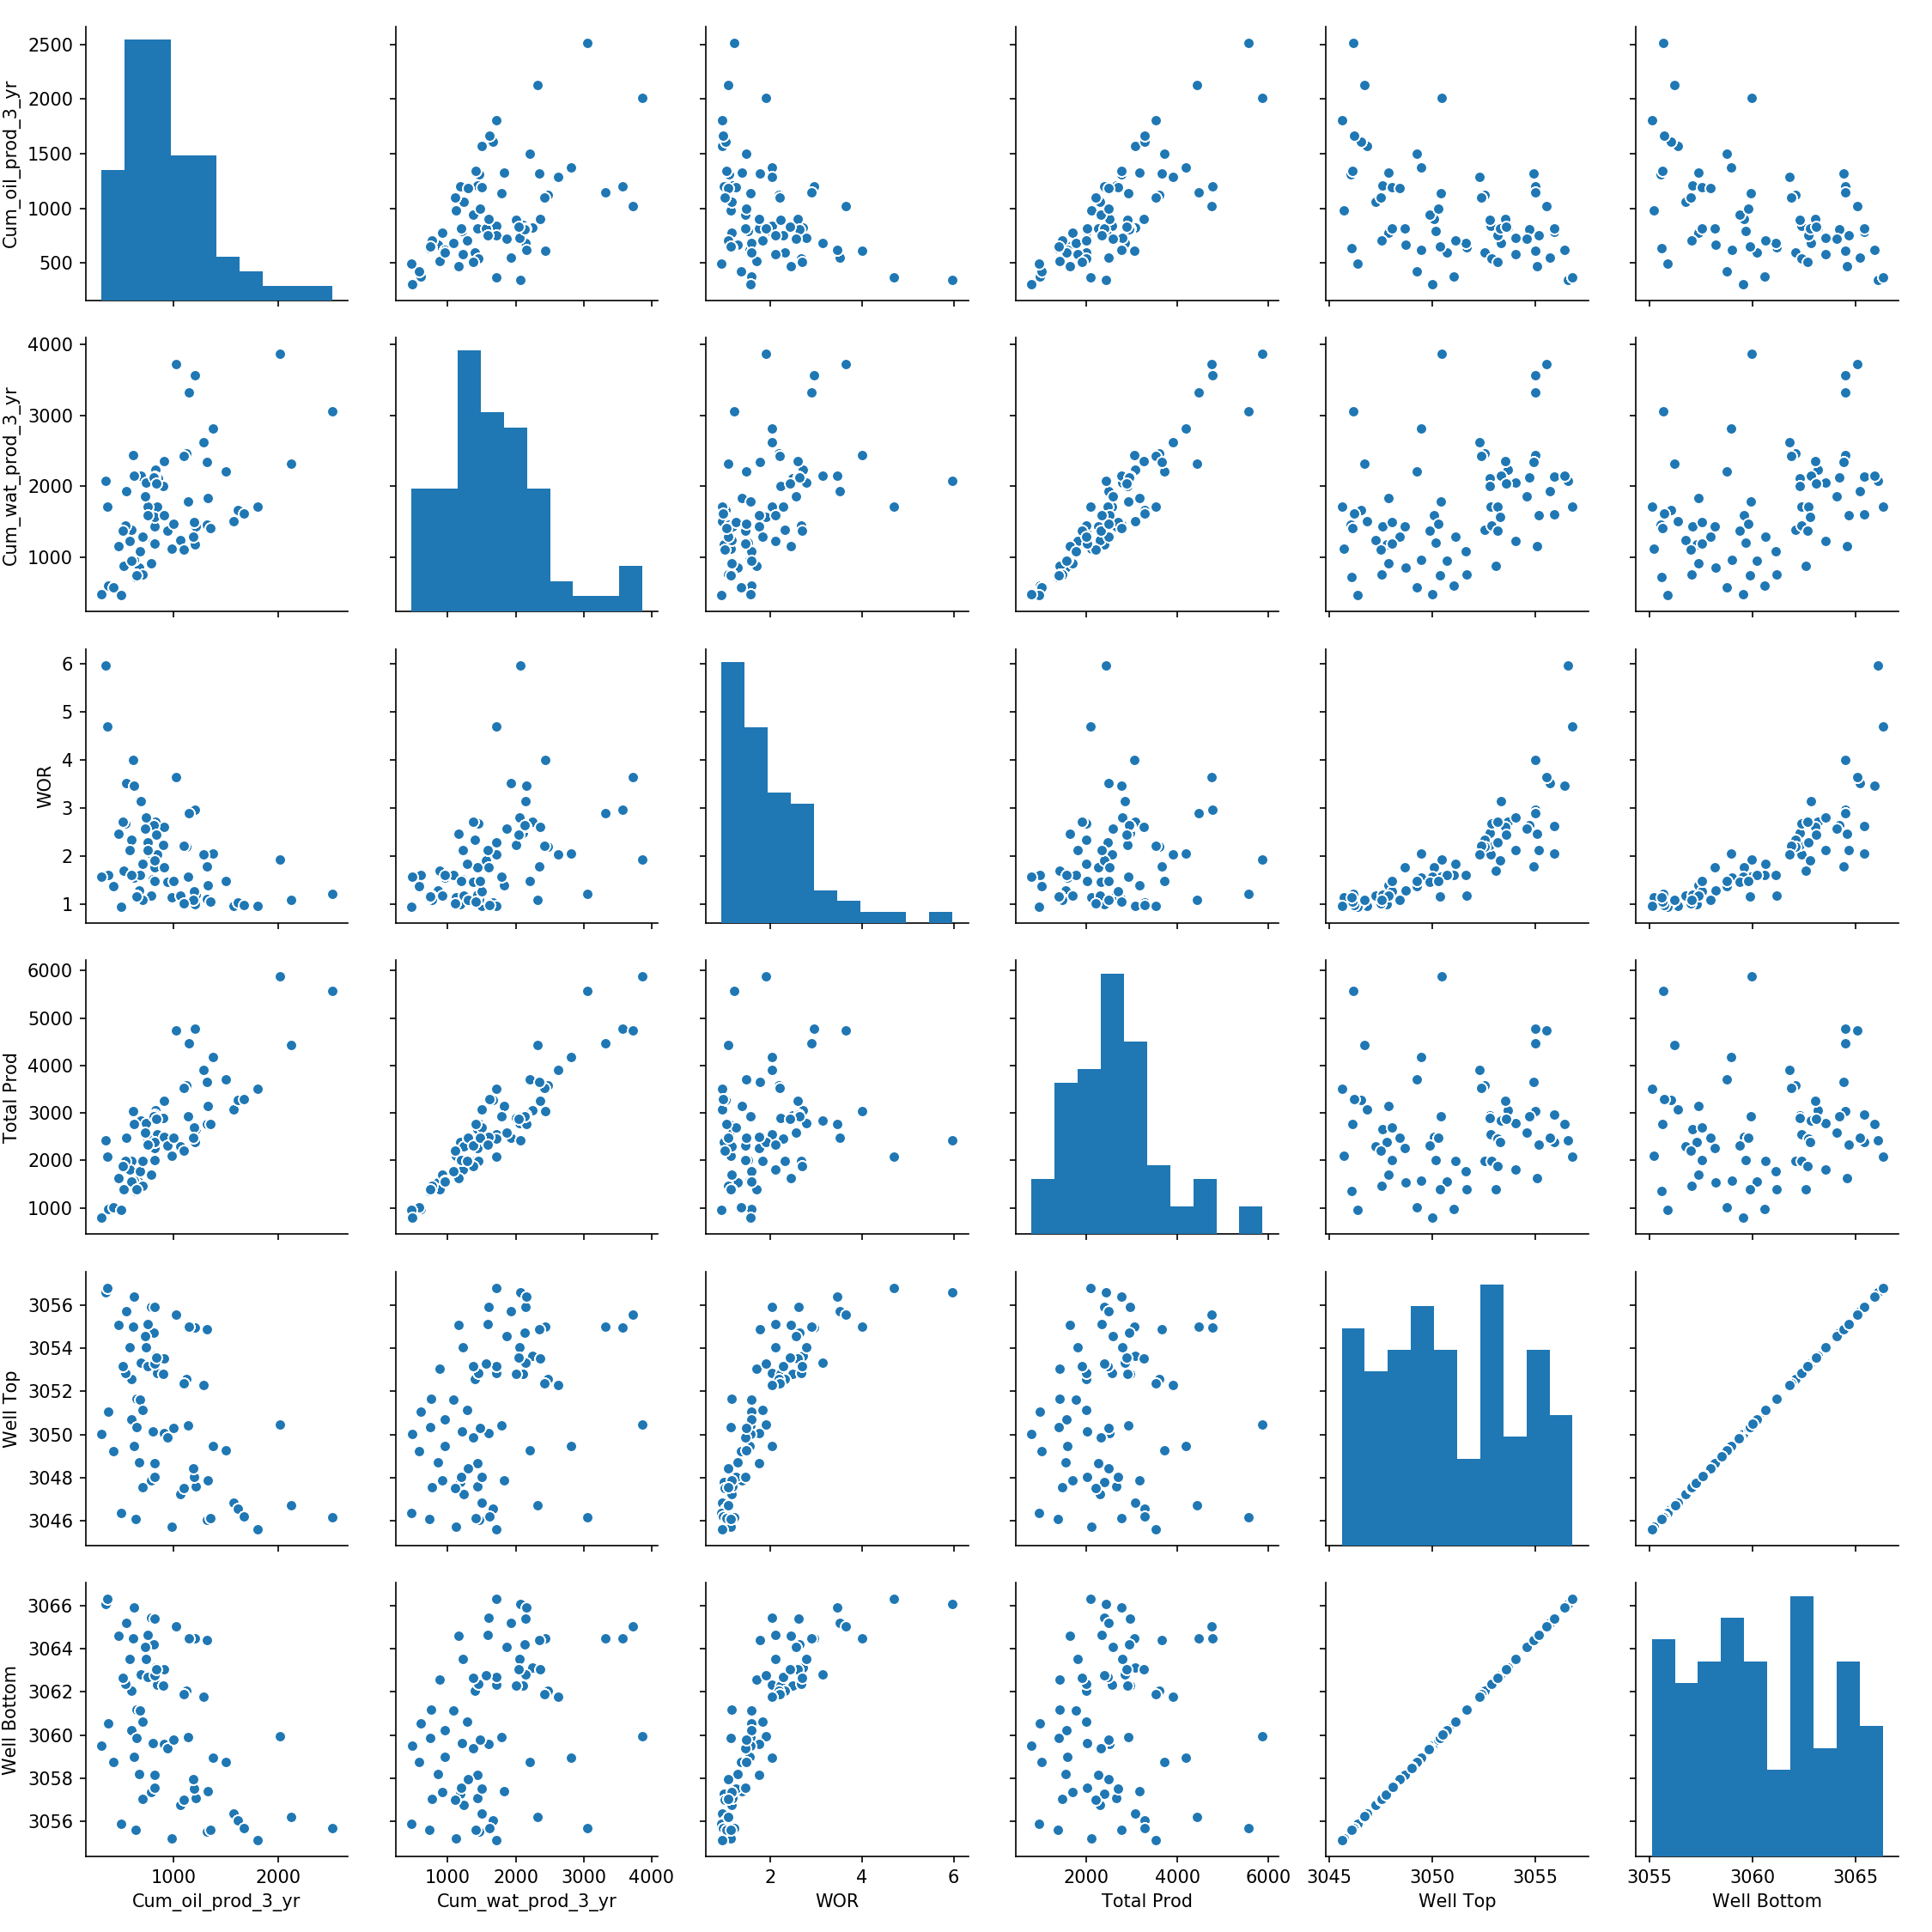

C:\Users\dchat\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\dchat\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [12]:
sns.pairplot(df_complete[['Cum_oil_prod_3_yr','Cum_wat_prod_3_yr','WOR','Total Prod','Well Top','Well Bottom']])

<IPython.core.display.Javascript object>


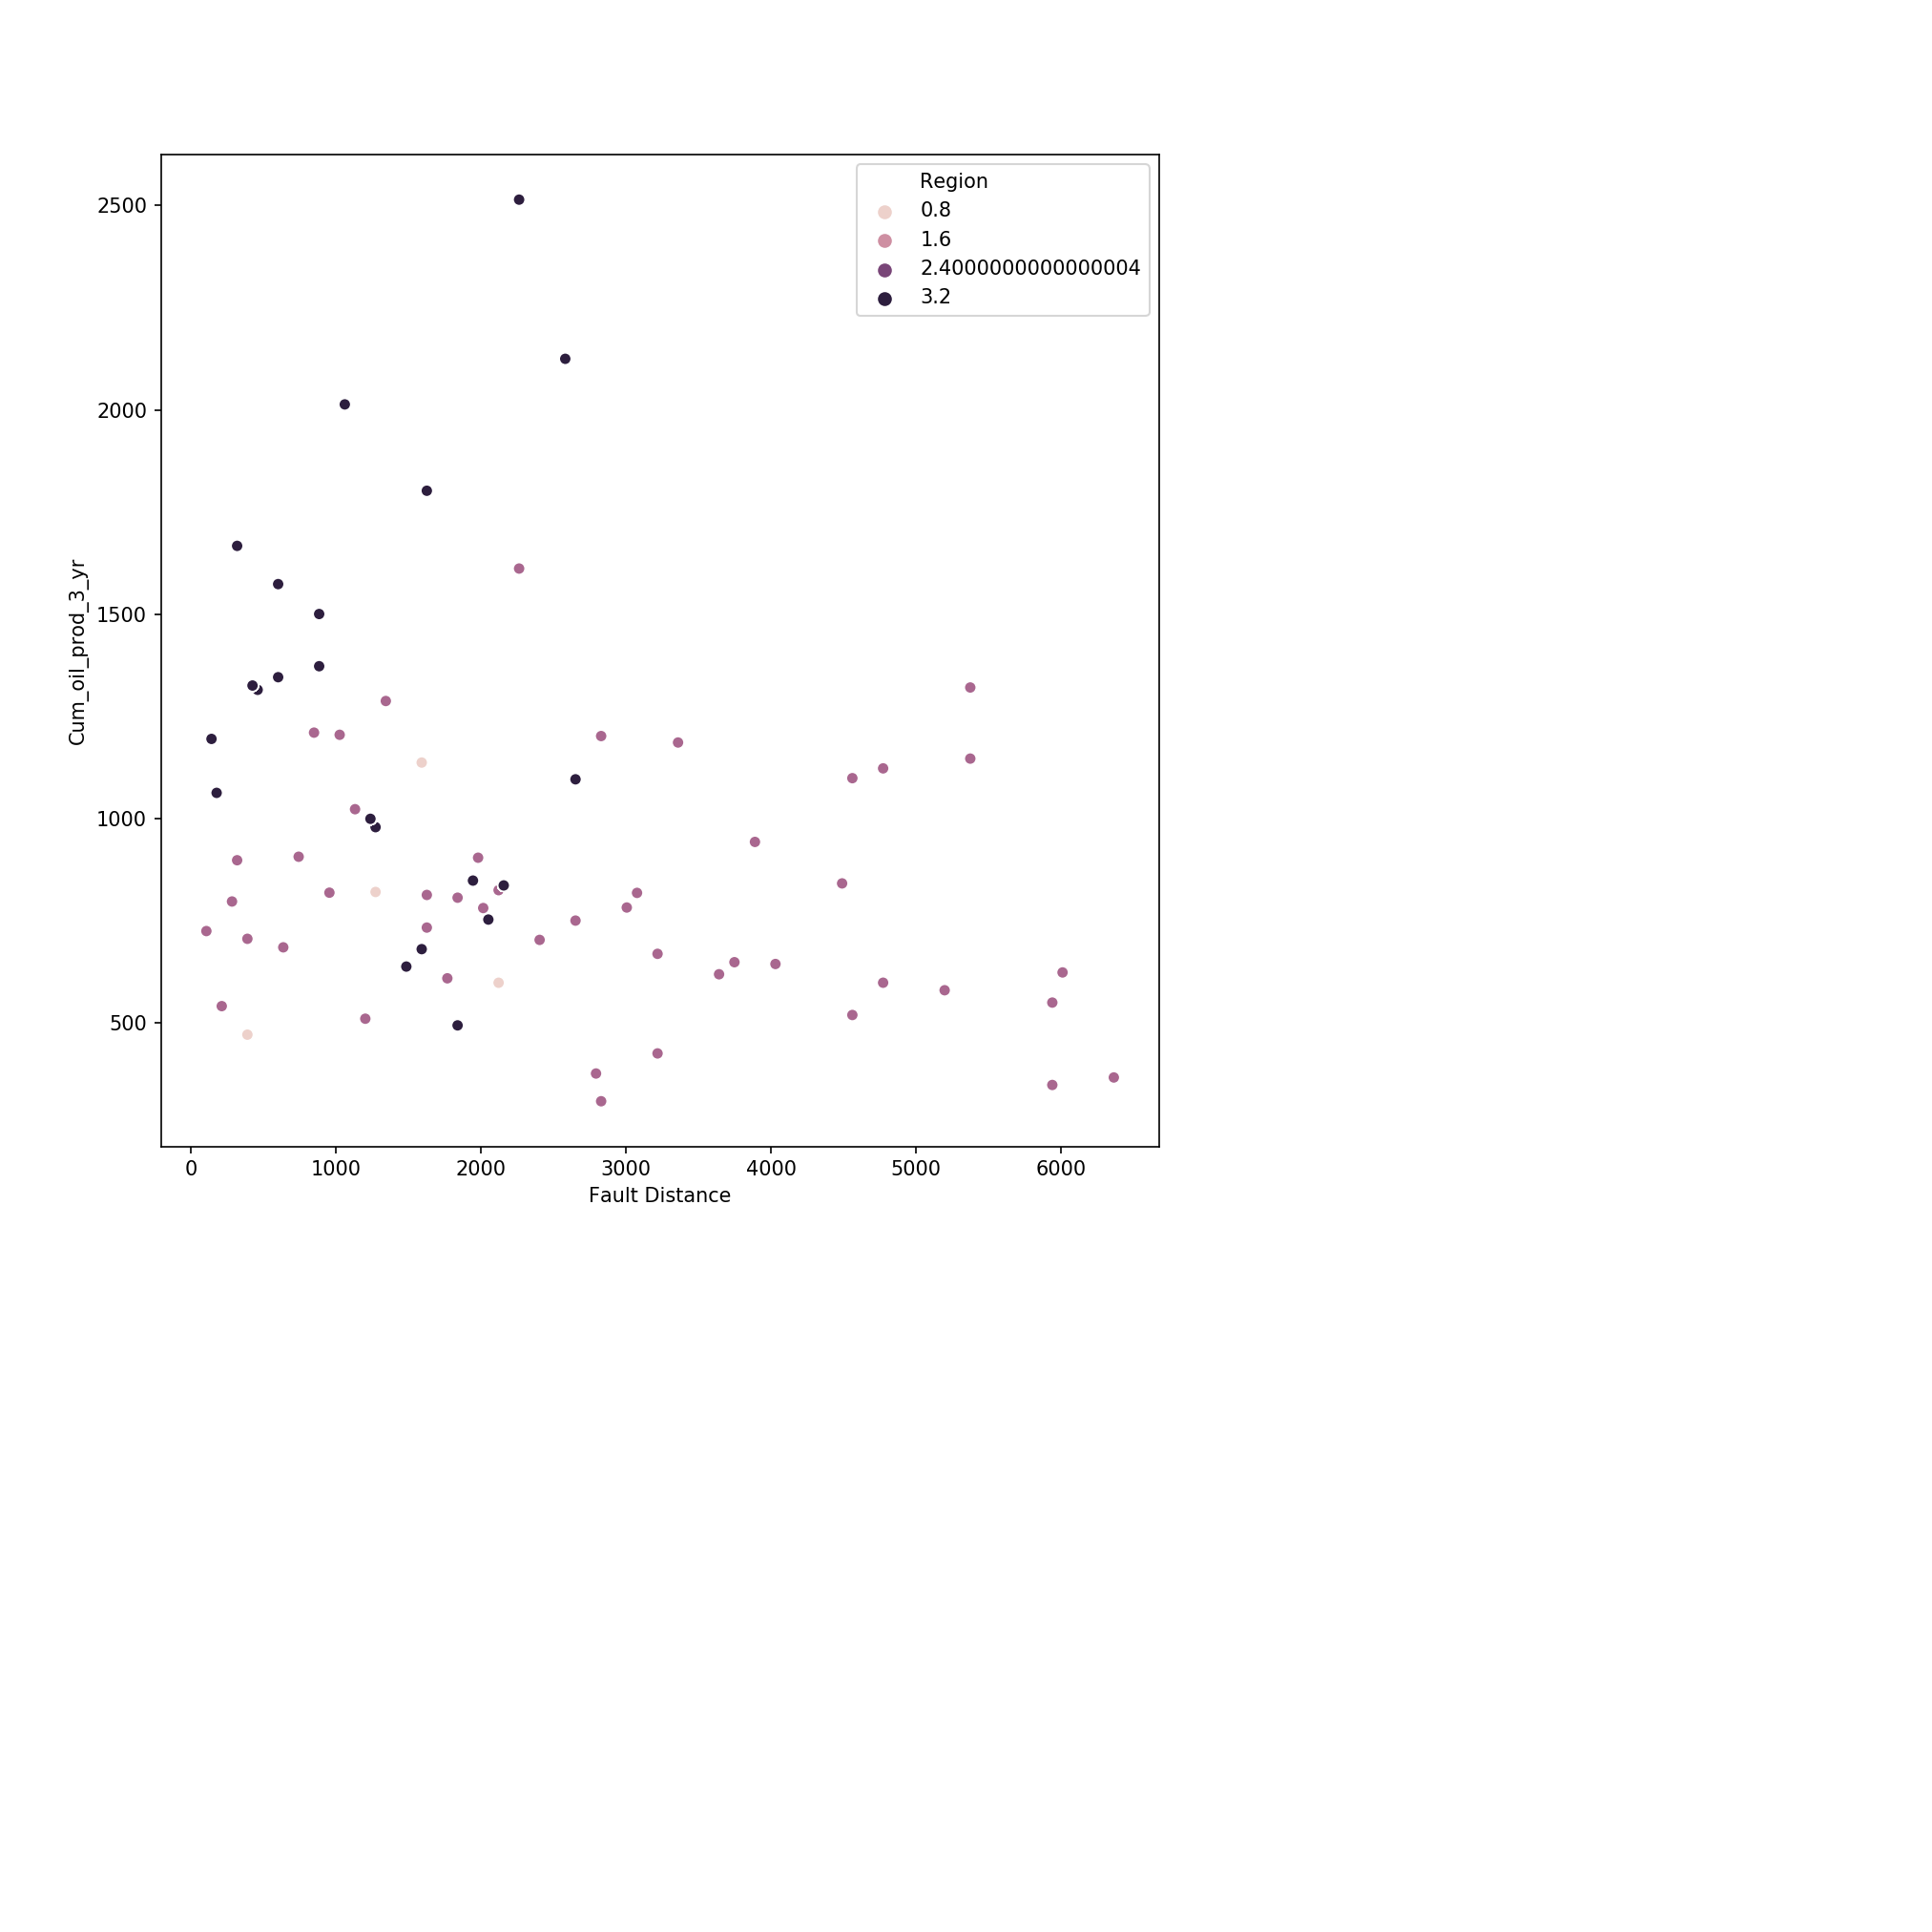

In [13]:
plt.figure(figsize = (9,9))
sns.scatterplot(data = df_complete, x = 'Fault Distance', y = 'Cum_oil_prod_3_yr', hue = 'Region')

<IPython.core.display.Javascript object>


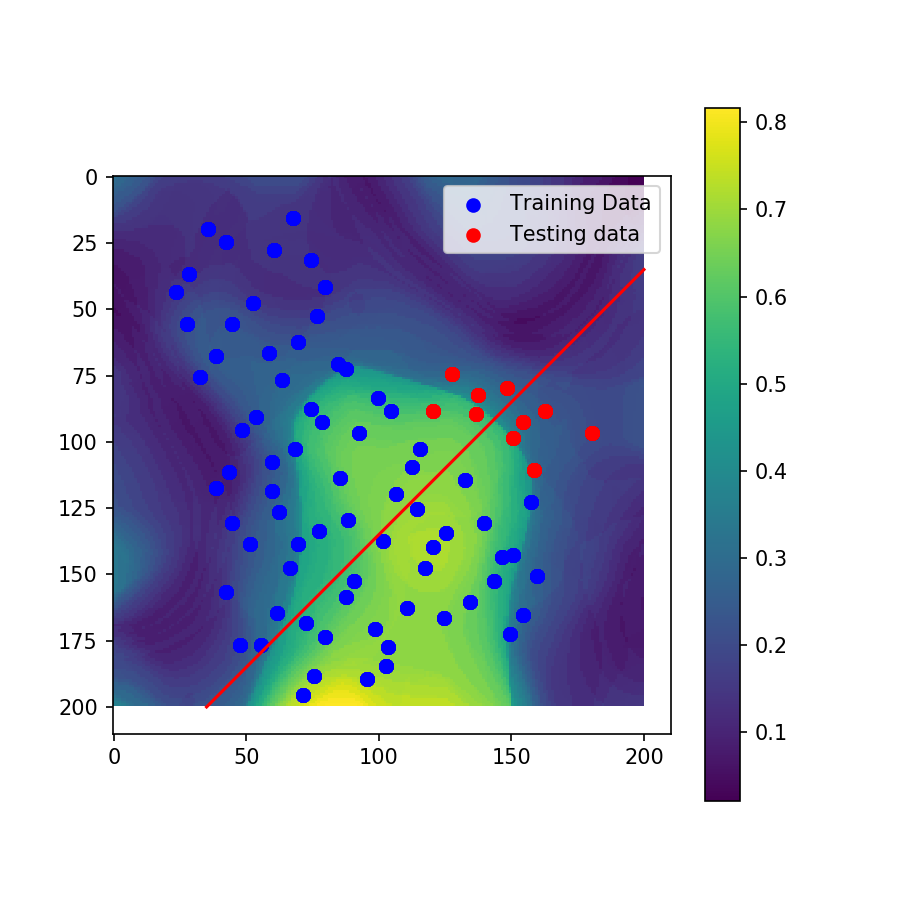

In [14]:

fig, ax = plt.subplots(figsize = (6, 6))

im = ax.imshow(resFraction)
a1 =  ax.scatter(df_producer['X, m']/50, df_producer['Y, m']/50, c = 'blue')
a2 = ax.scatter(df_preProc['X, m']/50, df_preProc['Y, m']/50, c = 'red')
ax.plot([10000/50, 1750/50], [1750/50, 10000/50], 'r')
ax.legend([a1, a2], ['Training Data', 'Testing data'])
fig.colorbar(im)